In [1]:

# %% Change the working directory
import os
# os.chdir('D:/STAT6011/2022/Example Class 4/CodeEC4')
os.getcwd()

'/Users/bilalbai/Desktop/MStat/STAT6011 Computational Statistics/tut/Example Class 4-20221011'

# Example Class 4 
## Bayesian Linear Regression

 Dataset: ``data.csv``
Linear regression model:
$$ y=\beta_0 + \beta_1 x_1+ \beta_2 x_2 +\epsilon,$$
where $\epsilon\sim N(0, \sigma^2)$.


In [1]:
# %% Import packages
import numpy as np
import pandas as pd
from numpy.random import multivariate_normal ,gamma ,seed
from scipy.stats import chi2 ,  f, t ,norm

# %% Load the data
dat =pd.read_csv('/Users/bilalbai/Desktop/MStat/STAT6011_Computational_Statistics/tut/Example Class 4-20221011/data.csv')




In [6]:
X= np.hstack((np.ones((len(dat), 1)), dat.values[:, 0:2]))
y = dat.values[:, 2]

In [3]:
dat.head()

,X1,X2,Y
0,0.365964,0.122989,1.545433
1,0.764998,-0.798506,-0.835681
2,0.259332,-1.453424,-1.859917
3,0.764968,-0.312300,0.714322
4,0.035873,-0.697789,-0.496670


### Frequentist MLE:
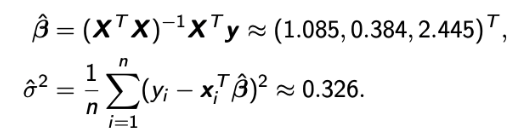

In [6]:

# %% Build the class of linear model
class LinearModel():
    def __init__(self, beta=None, sigma=None):
        self.beta = beta
        self.sigma = sigma

    def fit(self, X=None, y=None):
        n = len(y)
        self.beta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
        # MLE so the denominator is n
        H = np.dot(np.dot(X, np.linalg.inv(np.dot(X.T, X))), X.T)
        self.sigma = np.sqrt(np.dot(np.dot(y.T, np.eye(len(y)) - H), y) / n)

    def waldtest(self, ind_set=None, X=None, y=None, approx = False):
        # ind_set: indices of the features whose coefficients equal to 0 under
        #          null hypothesis (list)
        n = len(y)
        p = X.shape[1]
        d = len(ind_set)
        beta = self.beta[ind_set]
        sigma2 = self.sigma ** 2
        mat_inv = np.linalg.inv(np.dot(X.T, X))
        var_mat = sigma2 * n / (n-p) * mat_inv[ind_set, :]
        var_mat = var_mat[:, ind_set]
        # wald statistic
        if (d == 1):
            ws = np.sqrt(beta ** 2 / var_mat)
            if (approx):
                return 2*(1 - norm.cdf(ws))
            else:
                return 2*(1 - t.cdf(ws, df = n-p))
        else:
            ws = np.dot(np.dot(beta.T, np.linalg.inv(var_mat)), beta)
            # wald statistic follow chisquare distribution with d degrees of freedom
            return np.float(1 - chi2.cdf(ws, d))  # ,ws

    def likelihood(self, X=None, y=None):
        n = len(y)
        err = y - np.dot(X, self.beta)
        return 1 / (np.sqrt(2 * np.pi) * self.sigma) ** n * np.exp(-0.5 * np.dot(err.T, err) / self.sigma ** 2)

    def asylrt(self, ind_set=None, X=None, y=None):
        d = len(ind_set)
        # log likelihood under H
        ll = np.log(self.likelihood(X, y))
        # log likelihood under H0
        lm_con = LinearModel()
        lm_con.fit(np.delete(X, tuple(ind_set), axis=1), y)
        ll0 = np.log(lm_con.likelihood(np.delete(X, tuple(ind_set), axis=1), y))
        # test statistic
        ts = 2 * (ll - ll0)
        return np.float(1 - chi2.cdf(ts, d))



In [7]:
# Linear Regression, MLE
lm = LinearModel()
lm.fit(X, y)
beta = lm.beta
sigma = lm.sigma
print('The MLE of betas are ', beta)
print('The MLE of sigma^2 is ', sigma ** 2)

The MLE of betas are  [1.08464929 0.38411469 2.44477568]
The MLE of sigma^2 is  0.32558609867098987


## Bayesian Linear Regression
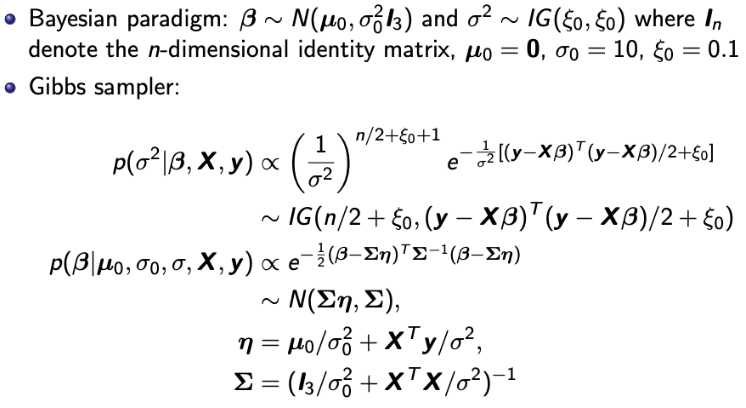

In [8]:


# %% Bayesian Linear Regression
def BayesianLM(X, y, N=int(1e4), burn=int(1e4), L=5, mu0=0, sigma0=10, xi0=.1, myseed=1):
    # X,y: data
    # N: sample size
    # burn: length of burn-in i.e. not choose any samples before brun
    # L: sample lag, thining interval
    # mu0=0: vector, prior mean of beta
    # sigma0: scalar, prior variance of beta
    # xi0: scalar, prior parameters of inverse-gamma
    # myseed: seed of generator
    n, p = X.shape
    x = np.zeros((p + 1, N * L + burn))
    x[:p, 0] = np.mean(y)
    x[p, 0] = np.var(y)

    seed(myseed)
    for i in np.arange(1, N * L + burn):
        # update beta
        sd2 = x[p, i - 1]
        Sigma = np.linalg.inv(np.eye(p) / sigma0 ** 2 + np.dot(X.T, X) / sd2)
        eta = np.dot(Sigma, mu0 / sigma0 ** 2 + np.dot(X.T, y) / sd2)
        x[:p, i] = multivariate_normal(eta, Sigma, 1)
        # update sigma^2
        a = n / 2 + xi0
        e = y - np.dot(X, x[:p, i])
        b = xi0 + 0.5 * np.dot(e.T, e)
        x[p, i] = 1 / gamma(a, 1 / b, 1)

    return x[:p, np.arange(burn, N * L + burn, L)], x[p, np.arange(burn, N * L + burn, L)]

In [9]:

# Bayesian Linear Regression, Results
beta, sd2 = BayesianLM(X, y)
print('The means of posterior betas are ', np.mean(beta, 1))
print('The mean of sigma^2 is ', np.mean(sd2))
print('The variances of posterior betas are ', np.var(beta, 1))
print('The variance of sigma^2 is ', np.var(sd2))


The means of posterior betas are  [1.08463781 0.38240467 2.44481776]
The mean of sigma^2 is  0.3341510727414212
The variances of posterior betas are  [0.00733626 0.02331171 0.00183909]
The variance of sigma^2 is  0.0011565636018972232


## Bayesian Linear Regression w/ an interaction
$ y=\beta_0 + \beta_1 x_1+ \beta_2 x_2 + \beta_3 x_1 x_2 +\epsilon, ~~\epsilon\sim N(0, \sigma^2)$
### MLE vs Posterior

In [17]:

# New Model, with the interaction term
XX = np.c_[X, X[:, 1] * X[:, 2]]
lm1 = LinearModel()
lm1.fit(XX, y)
beta1 = lm1.beta
sigma1 = lm1.sigma
print('The MLE of betas are ', beta1)
print('The MLE of sigma^2 is ', sigma1 ** 2)


N = int(1e4)
beta, sd2 = BayesianLM(XX, y, N=N)
print('The means of posterior betas are ', np.mean(beta, 1))
print('The mean of sigma^2 is ', np.mean(sd2))
print('The variances of posterior betas are ', np.var(beta, 1))
print('The variance of sigma^2 is ', np.var(sd2))




The MLE of betas are  [1.00703699 0.51828031 2.03663299 0.75405069]
The MLE of sigma^2 is  0.29466769369233525
The means of posterior betas are  [1.00758688 0.51766953 2.03546593 0.75552621]
The mean of sigma^2 is  0.3046733242632571
The variances of posterior betas are  [0.00693327 0.02192551 0.00966223 0.02740811]
The variance of sigma^2 is  0.0009796301940216718


In [13]:
1e-10 * 1e10


1.0

### Two sided hypothesis test
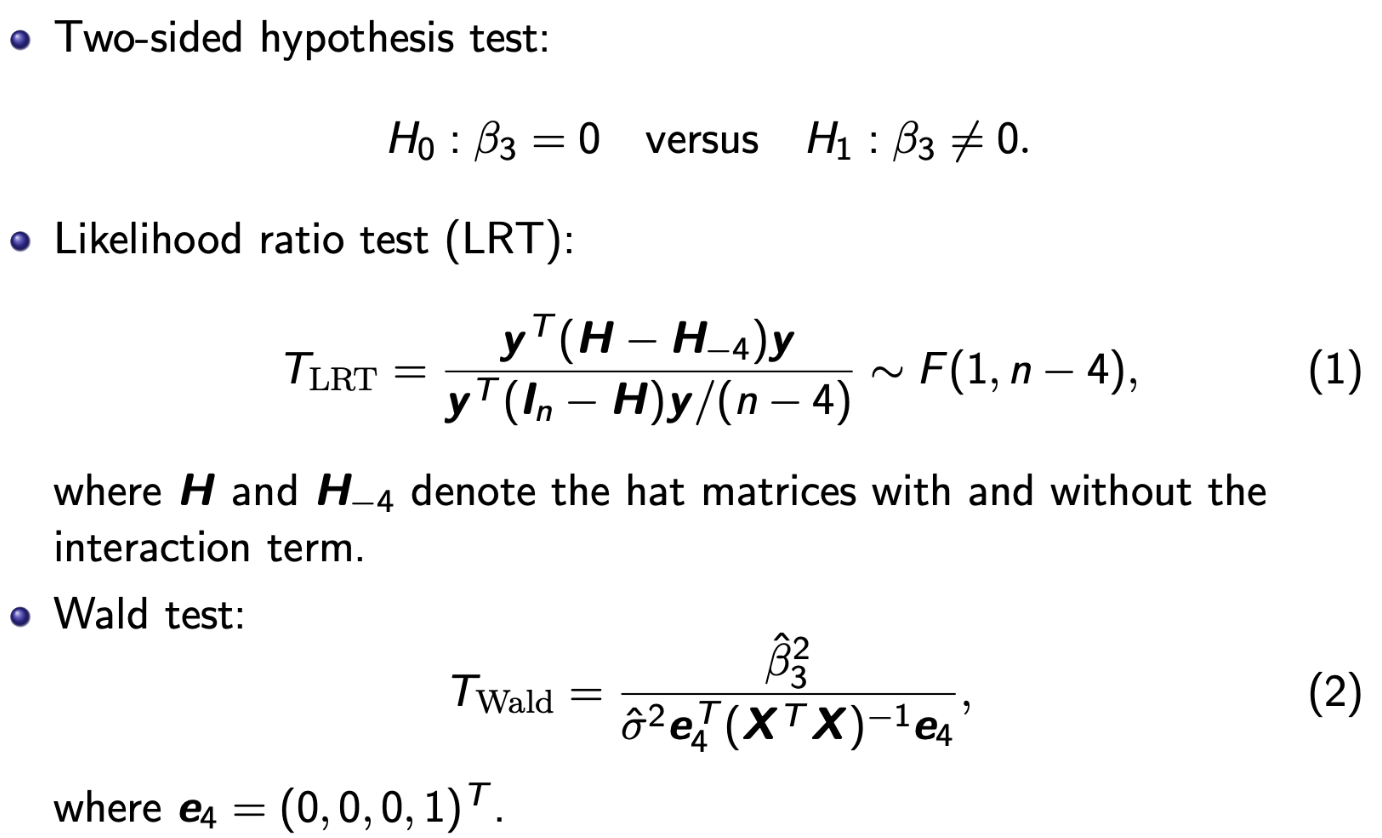
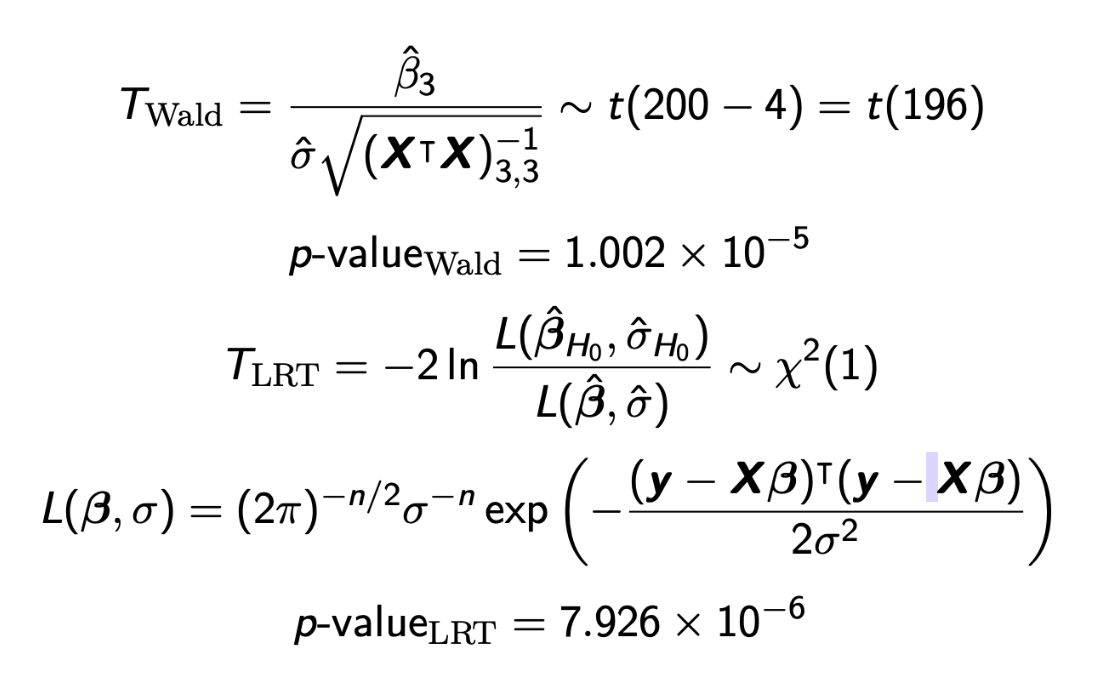

In [9]:

# wald test
print('p-value of wald test is ', lm1.waldtest([3], XX, y))
# wald test asymptotic
print('p-value of asymptotic wald test is ', lm1.waldtest([3], XX, y, approx = True))



p-value of wald test is  [[1.00220667e-05]]
p-value of asymptotic wald test is  [[5.76233725e-06]]


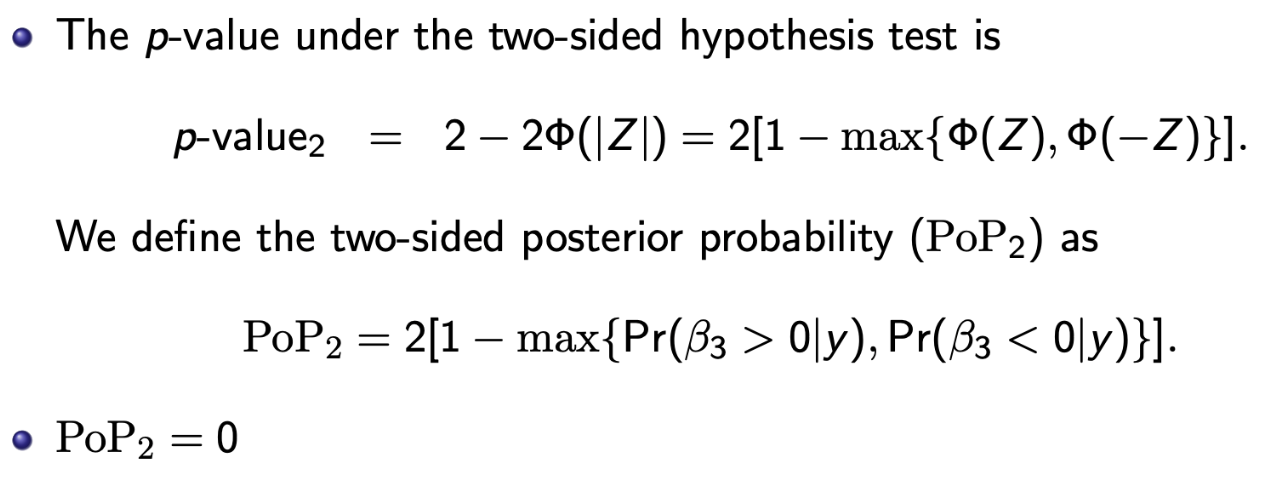

In [10]:

# asympotic lrt
print('p-value of asympotic lrt is ', lm1.asylrt([3], XX, y))

# bayesian
pg0 = np.mean(beta[3, :] > 0)  # probability beta3>0
pl0 = np.mean(beta[3, :] < 0)  # probability beta3<0
pop2 = 2 * (1 - max([pg0, pl0]))
print('The PoP2 is ', pop2)



p-value of asympotic lrt is  7.925583443757489e-06
The PoP2 is  0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
